P4: Guarda se fa freddo

Il dataset GlobalLandTemperaturesByMajorCity.csv (https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByMajorCity.csv) riporta la temperatura registrata nelle maggiori città del mondo a partire dal 1750. 

Usando questi dati, il progetto dovrà fornire una visualizzazione grafica efficace del variare delle temperature nel tempo, evidenziando le città in cui si sono registrate le maggiori escursioni termiche nei diversi periodi storici.
Per la visualizzazione dei dati su mappa si veda geopandas.

Il programma inoltre dovrà suggerire, a seconda del periodo considerato, il percorso migliore da seguire per un viaggatore freddoloso che intenda spostarsi da Pechino a Los Angeles muovendosi tappa dopo tappa verso la città più calda fra le 3 a lui più vicine.

OSS: Il progetto è stato effettuato sul dataset GlobalLandTemperaturesByCity.csv di circa ~500MB che contiene dati su molte più città rispetto al dataset indicato nella traccia.

In [1]:
# Import delle librerie

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

IMPORT DEI DATI

I dati sono importati con una manipolazione sui campi 'Latitude' e 'Longitude'. Questi sono in formato stringa, es. (57.05N, 10.33O) e devono essere convertiti in float, es (57.05, -10.33) per poter costruire punti geometrici con la libreria geopandas.
Inoltre vengono aggiunti i campi 'year' e 'month', partendo dal campo 'dt' che ha formato yyyy-mm-dd. Su 'year' e 'month' saranno fatti i raggruppamenti per il calcolo della temperatura media.

In [2]:
def casting_lat_long_to_float(string):
    if string[-1] in ('N','E'):
        return float(string[:-1])
    else:
        return -float(string[:-1])

def dt_to_year(string):
    return int(string[0:4])

def dt_to_month(string):
    return int(string[5:7])


converters = {'Latitude': casting_lat_long_to_float, 'Longitude': casting_lat_long_to_float} # dizionario contenente i campi e le relative funzioni da applicare in fase di import
data = pd.read_csv("./GlobalLandTemperaturesByCity/GlobalLandTemperaturesByCity.csv", converters = converters) # import dei dati
data['year'] = data.apply(lambda row: dt_to_year(row['dt']), axis=1) # creazione colonna year
data['month'] = data.apply(lambda row: dt_to_month(row['dt']), axis=1) # creazione colonna month

In [3]:
data # visualizzazione dei dati importati

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05,10.33,1743,11
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05,10.33,1743,12
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05,10.33,1744,1
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05,10.33,1744,2
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05,10.33,1744,3
...,...,...,...,...,...,...,...,...,...
8599207,2013-05-01,11.464,0.236,Zwolle,Netherlands,52.24,5.26,2013,5
8599208,2013-06-01,15.043,0.261,Zwolle,Netherlands,52.24,5.26,2013,6
8599209,2013-07-01,18.775,0.193,Zwolle,Netherlands,52.24,5.26,2013,7
8599210,2013-08-01,18.025,0.298,Zwolle,Netherlands,52.24,5.26,2013,8


VISUALIZZAZIONE GRAFICA

Si vuole visualizzare graficamente il variare delle temperature nel tempo, evidenziando le aree del mondo in cui si sono registrate le maggiori escursioni termiche nei diversi periodi storici. 

Verrà utilizzato uno scatterplot delle città sulla mappa del mondo. Queste città saranno colorate con una sfumatura che tra blu scuro e rosso scuro che indica se la città è stata mediamente più fredda oppure mediamente più calda rispetto alla media su tutto il periodo storico.

PULIZIA DEI DATI

Le operazioni indicate sopra richiedono uno step preliminare di pulizia dei dati, dal momento che alcuni record non hanno il campo AverageTemperature popolato (NaN). Questo crea un problema per il calcolo della temperatura media annuale. Per esempio, nel caso in cui mancassero i dati relativi ai mesi estivi, allora l'anno risulterebbe mediamente freddo. 
Per ovviare a questo problema si è deciso di valorizzare il campo 'AverageTemperature' con la media mensile su tutto l'arco temporale.

Inoltre ci sono anni in cui alcune città non hanno tutte le temperature mensili. In questo caso si è deciso di rimuovere tutti record relativi a quell'anno e a quella città. Da un'analisi non riportata nel notebook si tratta degli anni 1743 e 2013.

In [4]:
def fill_nan_in_field(df, field, key_field):
    avg_field = df[key_field + [field]].groupby(key_field).mean() # dataframe with multiindex key_field and mean value for field
    for i, i_field_is_nan in enumerate(tqdm(df.loc[df[:][field].isnull()].index)): # loop where field is null
        df.at[i_field_is_nan, field] = avg_field.loc[tuple(df.loc[i_field_is_nan, key_field].values)][field] # fill field with the average

In [5]:
fill_nan_in_field(data, 'AverageTemperature', ['month', 'City', 'Country']) # riempire i dati mancanti con la media del mese su tutto l'arco temporale

  0%|          | 0/364130 [00:00<?, ?it/s]

In [7]:
key_group_year = ['year', 'City', 'Country', 'Latitude', 'Longitude']
count_month_per_year_city = data[['month'] + key_group_year].drop_duplicates().groupby(key_group_year).count().reset_index()
row_to_remove = count_month_per_year_city[count_month_per_year_city['month'] != 12]
row_to_remove = row_to_remove.rename(columns={'month': 'to_remove'})
data = pd.merge(data, row_to_remove,  how='left', on = key_group_year, validate='m:1')
data = data.loc[data['to_remove'].isnull()][['dt', 'year', 'month', 'City', 'Country', 'Latitude', 'Longitude', 'AverageTemperature']]

SALVATAGGIO

Le operazioni effettuate sono risultate onerose. Per non eseguirle nuovamente il dataset viene salvato in modo da poter essere caricato con tutte le proprietà attese.

In [8]:
data[['year', 'month', 'City', 'Country', 'Latitude', 'Longitude', 'AverageTemperature']].to_json('./GlobalLandTemperaturesByCity_NaN_filled.json')

CARICAMENTO

Caricamento dei dati pre-processati.

In [9]:
data = pd.read_json('./GlobalLandTemperaturesByCity_NaN_filled.json')
data

,year,month,City,Country,Latitude,Longitude,AverageTemperature
0,1744,1,Århus,Denmark,57.05,10.33,-0.496834
1,1744,2,Århus,Denmark,57.05,10.33,-0.125409
2,1744,3,Århus,Denmark,57.05,10.33,1.764966
3,1744,4,Århus,Denmark,57.05,10.33,5.788000
4,1744,5,Århus,Denmark,57.05,10.33,10.644000
...,...,...,...,...,...,...,...
8561467,2012,8,Zwolle,Netherlands,52.24,5.26,18.588000
8561468,2012,9,Zwolle,Netherlands,52.24,5.26,14.333000
8561469,2012,10,Zwolle,Netherlands,52.24,5.26,10.358000
8561470,2012,11,Zwolle,Netherlands,52.24,5.26,6.469000


CALCOLO MEDIA ANNUALE

In [10]:
key_group_year = ['year', 'City', 'Country', 'Latitude', 'Longitude']
data_avg_by_year = data[key_group_year + ['AverageTemperature']].groupby(key_group_year).mean().reset_index() # media per città e anno
data_avg_by_year

,year,City,Country,Latitude,Longitude,AverageTemperature
0,1744,A Coruña,Spain,42.59,-8.73,12.982800
1,1744,Aachen,Germany,50.63,6.34,8.655992
2,1744,Aalborg,Denmark,57.05,10.33,7.459827
3,1744,Aberdeen,United Kingdom,57.05,-1.48,8.079643
4,1744,Aix En Provence,France,44.20,4.47,11.196479
...,...,...,...,...,...,...
713451,2012,Århus,Denmark,57.05,10.33,8.399833
713452,2012,Çorlu,Turkey,40.99,27.69,14.853667
713453,2012,Çorum,Turkey,40.99,34.08,11.142333
713454,2012,Öskemen,Kazakhstan,50.63,82.39,1.372333


CALCOLO MEDIA SU TUTTO L'ARCO TEMPORALE

In [11]:
key_group = ['City', 'Country', 'Latitude', 'Longitude']
data_avg = data_avg_by_year[key_group + ['AverageTemperature']].groupby(key_group).mean().reset_index() # media città su tutto l'arco temporale 1744-2012
data_avg = data_avg.rename(columns={'AverageTemperature':'TotalAverageTemperature'})
data_avg

,City,Country,Latitude,Longitude,TotalAverageTemperature
0,A Coruña,Spain,42.59,-8.73,13.150727
1,Aachen,Germany,50.63,6.34,8.831146
2,Aalborg,Denmark,57.05,10.33,7.701882
3,Aba,Nigeria,5.63,8.07,26.604616
4,Abadan,Iran,29.74,48.00,25.036008
...,...,...,...,...,...
3505,Århus,Denmark,57.05,10.33,7.701882
3506,Çorlu,Turkey,40.99,27.69,13.323256
3507,Çorum,Turkey,40.99,34.08,9.937871
3508,Öskemen,Kazakhstan,50.63,82.39,1.300265


COSTRUZIONE CAMPO ESCURSIONE TERMICA

Al dataframe data_avg è affiancato, analogamente ad una JOIN del linguaggio SQL, il dataframe data_avg_by_year al fine di costruire il campo 'AverageTemperatureRange'. Questo campo indica, per ogni anno e città, l'escursione termica, ovvero la differenza tra la temperatura media di quell'anno e la temperatura media su tutto l'arco temporale. 
Un valore negativo di 'AverageTemperatureRange' indica un anno più freddo della media, mentre un valore positivo indica un anno più caldo della media. 
Questo sarà il campo utilizzato nella rappresentazione grafica.

In [12]:
join_field = ['City', 'Country', 'Latitude', 'Longitude']
info_data = pd.merge(data_avg_by_year, data_avg,  how='inner', on = join_field, validate='m:1') # join
info_data['AverageTemperatureRange'] = info_data['AverageTemperature'] - info_data['TotalAverageTemperature'] # new columns
info_data

,year,City,Country,Latitude,Longitude,AverageTemperature,TotalAverageTemperature,AverageTemperatureRange
0,1744,A Coruña,Spain,42.59,-8.73,12.982800,13.150727,-0.167927
1,1745,A Coruña,Spain,42.59,-8.73,12.945166,13.150727,-0.205560
2,1746,A Coruña,Spain,42.59,-8.73,13.152174,13.150727,0.001447
3,1747,A Coruña,Spain,42.59,-8.73,13.152174,13.150727,0.001447
4,1748,A Coruña,Spain,42.59,-8.73,13.152174,13.150727,0.001447
...,...,...,...,...,...,...,...,...
713451,2008,Tumbes,Peru,-4.02,-81.16,23.675667,23.036351,0.639315
713452,2009,Tumbes,Peru,-4.02,-81.16,23.777917,23.036351,0.741565
713453,2010,Tumbes,Peru,-4.02,-81.16,23.495750,23.036351,0.459399
713454,2011,Tumbes,Peru,-4.02,-81.16,23.510750,23.036351,0.474399


CREAZIONE GEODATAFRAME

Import della libreria geopandas e creazione dell'oggetto GeoDataFrame.
Viene aggiunta la colonna 'geometry' partendo da Latitudine e Longitudine e che indica le coordinate geografiche.

In [13]:
import geopandas as gpd

In [14]:
gid = gpd.GeoDataFrame(info_data, geometry=gpd.points_from_xy(info_data.Longitude, info_data.Latitude)) # geoinfodata
gid

,year,City,Country,Latitude,Longitude,AverageTemperature,TotalAverageTemperature,AverageTemperatureRange,geometry
0,1744,A Coruña,Spain,42.59,-8.73,12.982800,13.150727,-0.167927,POINT (-8.73000 42.59000)
1,1745,A Coruña,Spain,42.59,-8.73,12.945166,13.150727,-0.205560,POINT (-8.73000 42.59000)
2,1746,A Coruña,Spain,42.59,-8.73,13.152174,13.150727,0.001447,POINT (-8.73000 42.59000)
3,1747,A Coruña,Spain,42.59,-8.73,13.152174,13.150727,0.001447,POINT (-8.73000 42.59000)
4,1748,A Coruña,Spain,42.59,-8.73,13.152174,13.150727,0.001447,POINT (-8.73000 42.59000)
...,...,...,...,...,...,...,...,...,...
713451,2008,Tumbes,Peru,-4.02,-81.16,23.675667,23.036351,0.639315,POINT (-81.16000 -4.02000)
713452,2009,Tumbes,Peru,-4.02,-81.16,23.777917,23.036351,0.741565,POINT (-81.16000 -4.02000)
713453,2010,Tumbes,Peru,-4.02,-81.16,23.495750,23.036351,0.459399,POINT (-81.16000 -4.02000)
713454,2011,Tumbes,Peru,-4.02,-81.16,23.510750,23.036351,0.474399,POINT (-81.16000 -4.02000)


IMPORT LIBRERIE GRAFICHE

In [15]:
import matplotlib.pyplot as plt # per fare i grafici ed avere una legenda
from mpl_toolkits.axes_grid1 import make_axes_locatable # vertically align the plot axes and the legend axes
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap

FUNZIONE get_palette

Ad ogni valore di 'AverageTemperatureRange' viene assegnato un colore in modo tale che i valori più bassi siano blu scuro, i più alti rosso scuro e i restanti valori siano rappresentati da colori intermedi (matplotlib colormap RedBlu_reversal).
In questo modo è possibile confrontare visivamente le escursioni termiche tra due anni diversi.

In [16]:
def get_palette(df, field):
    """
    Mappa i valori del campo field in una paletta di colori (dizionario). df = pandas.DataFrame, field = string.
    ## Funziona se il numero di valori unici del campo field é molto maggiore di 255.
    ## Da perfezionare rendendo variabile la colormap di matplotlib (e.g. inferno anziché RdBu_r)
    """
    ordered_field = sorted(df[field].unique()) # ottengo una lista
    first_positive = [i for i, x in enumerate(ordered_field) if x >= 0][0]
    number_unique_negative = first_positive
    number_unique_positive = len(ordered_field) - first_positive
    number_values_for_negative = number_unique_negative//127
    number_values_for_positive = 128 + number_unique_positive//127
    
    palette = dict(zip(ordered_field, [cm.RdBu_r(x//number_values_for_negative) if x < first_positive else cm.RdBu_r(x//number_values_for_positive) for x in range(len(ordered_field))]))
    
    return palette


palette = get_palette(gid,'AverageTemperatureRange')

STAMPA DELL'IMMAGINE

Le città sono rappresentate con dei punti colorati sulla mappa del mondo. Il colore da utilizzare per lo specifico valore di 'AverageTemperatureRange' è stato definito dalla funzione get_palette. La variabile custom_map contiene la color map da utilizzare per l'anno specifico. 

OSS: Le label della legenda sono state rimosse perché assegnano ai colori un valore uniformemente distribuito tra il minimo ed il massimo dello specifico anno. Si consideri ad esempio l'anno 1888. La legenda assegnerebbe al valore 0 un colore azzurro. Per come è stata costruita la paletta, invece, al valore 0 è assegnato il colore bianco.

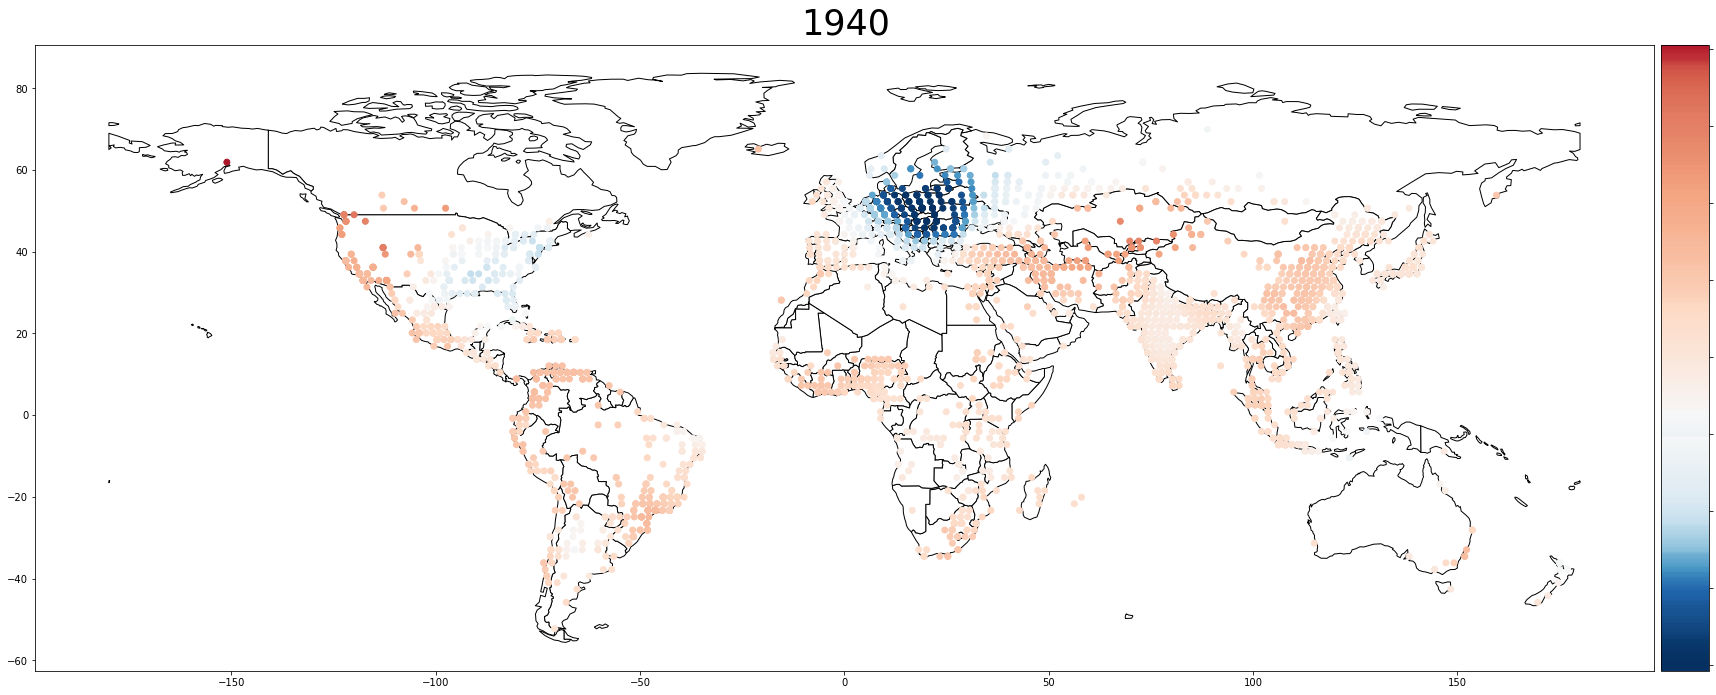

In [17]:
%matplotlib inline

year = 1940
#year = 1888

field = 'AverageTemperatureRange'
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
background = world[(world.name!="Antarctica")].plot(color='white', edgecolor='black', figsize=(30, 30))
fig = background.get_figure()
gdf_to_plot = gid[gid['year']==year].sort_values(field)

custom_cmap = ListedColormap([color for value, color in palette.items() if value in gdf_to_plot[field].unique()])

# aggiungiamo al grafico la mappa colori
divider = make_axes_locatable(background)
cax = divider.append_axes("right", size="3%", pad=0.1)
vmin = gdf_to_plot[field].min()
vmax = gdf_to_plot[field].max()
gdf_to_plot.plot(column=field, ax=background, legend=True, cax=cax, cmap=custom_cmap, vmin=vmin, vmax=vmax)

fig.get_axes()[1].set_yticklabels([]) # rimozione dei tick dall'asse colori

title = plt.figtext(.5, .6525, year, fontsize=35, ha='center') # set title    

SALVARE LE IMMAGINI SU FILE

In [ ]:
def print_colored_world_map_over_file(world, gdf, field, palette, path):
    
    background = world[(world.name!="Antarctica")].plot(color='white', edgecolor='black', figsize=(30, 30))
    fig = background.get_figure()
    gdf_to_plot = gdf.sort_values(field)
    
    custom_cmap = ListedColormap([color for value, color in palette.items() if value in gdf_to_plot[field].unique()]) # sembra l'operazione più costosa
    
    # aggiungiamo al grafico la mappa colori
    divider = make_axes_locatable(background)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    vmin = gdf_to_plot[field].min()
    vmax = gdf_to_plot[field].max()
    gdf_to_plot.plot(column=field, ax=background, legend=True, cax=cax, cmap=custom_cmap, vmin=vmin, vmax=vmax)
    fig.get_axes()[1].set_yticklabels([])
    title = plt.figtext(.5, .6525, year, fontsize=35, ha='center') # set title    
    plt.savefig(path, bbox_inches='tight')
    plt.close(fig)

CICLO CREAZIONE IMMAGINI 

Tempo di esecuzione 2h (30s a immagine circa), richiede che il path relativo ./images2/ sia valido.

In [ ]:
%matplotlib
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
for i, year in enumerate(geodata_info_data['year'].unique()):
    print_colored_world_map_over_file(world, geodata_info_data[geodata_info_data['year']==year], 'AverageTemperatureRange', palette, './images2/avg_temp_' + str(year) + '.png')

CREAZIONE VIDEO

Le immagine create precedentemente possono essere unite in un video. Così facendo la barra di avanzamento può essere utilizzata per scegliere velocemente l'anno.

In [18]:
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import glob
image_list = []
for filename in glob.glob('./images2/*.png'): 
    im = Image.open(filename)
    image_list.append(im)

fig = plt.figure(figsize=(14, 14))
ims = []
for i in range(len(image_list)):
    im = plt.imshow(image_list[i], animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=475, blit=False, repeat_delay=1000)
plt.close()

# Show the animation
HTML(ani.to_html5_video())

IL VIAGGIATORE FREDDOLOSO

Fissato l'anno bisogna indicare il percorso migliore da seguire per un viaggatore freddoloso che intenda spostarsi da Pechino a Los Angeles muovendosi tappa dopo tappa verso la città più calda fra le 3 a lui più vicine.

Per l'implementazione si suppone che da ogni città sia possibile raggiungere tutte le altre città e che il viaggiatore non torni mai in una città già visitata. In questo modo il viaggiatore è sicuro di raggiungere la sua destinazione.

FISSARE L'ANNO

Si fissa l'anno di interesse e si costruisce un geodataframe con le temperature medie di quell'anno, città per città.
L'indice del geodataframe viene resettato da 0 a numero di record nel dataframe meno uno. In questo modo l'indice può essere utilizzato per identificare univocamente una città all'interno di liste e array numpy.

In [19]:
year = 2011

data_year_of_trip = data_avg_by_year[data_avg_by_year['year']==year].reset_index()
gdf = gpd.GeoDataFrame(data_year_of_trip, geometry=gpd.points_from_xy(data_year_of_trip.Longitude, data_year_of_trip.Latitude))
gdf

,index,year,City,Country,Latitude,Longitude,AverageTemperature,geometry
0,706436,2011,A Coruña,Spain,42.59,-8.73,14.585500,POINT (-8.73000 42.59000)
1,706437,2011,Aachen,Germany,50.63,6.34,10.654667,POINT (6.34000 50.63000)
2,706438,2011,Aalborg,Denmark,57.05,10.33,9.181167,POINT (10.33000 57.05000)
3,706439,2011,Aba,Nigeria,5.63,8.07,27.388083,POINT (8.07000 5.63000)
4,706440,2011,Abadan,Iran,29.74,48.00,26.019833,POINT (48.00000 29.74000)
...,...,...,...,...,...,...,...,...
3505,709941,2011,Århus,Denmark,57.05,10.33,9.181167,POINT (10.33000 57.05000)
3506,709942,2011,Çorlu,Turkey,40.99,27.69,13.577500,POINT (27.69000 40.99000)
3507,709943,2011,Çorum,Turkey,40.99,34.08,10.016250,POINT (34.08000 40.99000)
3508,709944,2011,Öskemen,Kazakhstan,50.63,82.39,1.784500,POINT (82.39000 50.63000)


L'algoritmo restituisce una lista di indici che, se utilizzata per accedere al geodataframe, permette di ottenere l'elenco delle città che il viaggiatore deve visitare in ordine per soddisfare i requisiti richiesti.

PSEUDOCODICE (ricordando che idx rapprensenta una città)

1 - Inizializzare idx = idx_start, idx_end, un array contenente le temperature e trip = [idx]
2 - Inizializzare array booleano mask. I valori True indicano un idx già visitato
3 - while idx != idx_end:
        - calcolare la distanza tra idx e tutte le altre città non visitate
        - segnare idx come città già visitata
        - idx = indice della città più calda tra le tre più vicine

4 - trip

Inoltre vengono posizionati alcuni print per visualizzare il percorso.

In [ ]:
DEFINIZIONE DELLE FUNZIONI

In [20]:
def false_idx(low, bool_array):
    """
    Partendo dall'indice low, restituisce il successivo indice tra i valori falsi presenti in un array booleano. 
    """
    
    current = low
    while current < len(bool_array):
        if ~bool_array[current]:
            yield current
        current += 1
        

def distance_array_w_mask(gdf, mask, idx, geometry='geometry'):
    """
    Return an array with distance between a POINT and all other POINTS in a GeoDataFrame.
    Be careful! CRS is important, but not handled here!
    """

    dist_array = np.zeros(len(mask))
    for i in false_idx(0, mask): # questa forma tramite generatori dovrebbe essere equivalente al ciclo tramite lista
    #for i in [i for i, m in enumerate(mask) if ~m]:
        dist_array[i] = gdf.iloc[idx][geometry].distance(gdf.iloc[i][geometry])
    return dist_array


def next_city(dist_ma, temp_array, radius = 3):
    """
    Restituisce l'indice del più caldo tra i radius più vicini.
    dist_matrix = np.ma.array
    Le distanze presenti in dist_ma sono ordinate in modo crescente. Gli elementi mascherati vengono messi "in fondo".
    """
    closest = np.ma.argsort(dist_ma)[0:radius] # array di indici    
    print('closest = ',closest)
    print ('temp_array = ', temp_array[closest])
    return int(closest[temp_array[closest].argmax()]) # tra i più vicini quello con temp_array massimo

In [ ]:
INIZIALIZZARE LE VARIABILI

Poiché il dataset è composto da tante osservazioni, utilizzo un esempio per verificare il funzionamento.

In [21]:
start_city_country = ('Milan', 'Italy')
end_city_country = ('Mannheim', 'Germany')

#start_city_country = ('Peking', 'China')
#end_city_country = ('Los Angeles', 'United States')


idx = int(gdf[(gdf['City']==start_city_country[0]) & (gdf['Country']==start_city_country[1])].index.values) # indice di inizio
idx_end = int(gdf[(gdf['City']==end_city_country[0]) & (gdf['Country']==end_city_country[1])].index.values) # indice di fine
print('idx = ', idx, '   idx_end = ', idx_end)

idx =  1966    idx_end =  1877


In [22]:
temp_array = np.array(gdf['AverageTemperature'])
temp_array

array([14.5855    , 10.65466667,  9.18116667, ..., 10.01625   ,
        1.7845    ,  6.80608333])

In [23]:
trip = [idx] # vettore di indici che rappresenta il percorso

mask = np.array([False for i in range(len(gdf.index))]) # si suppone che l'indice del df (gdf?) sia 0-len(df)
while idx != idx_end:
    print('---------------------------')
    print('idx = ', idx, '  City =', gdf.iloc[idx]['City'], '  Country =', gdf.iloc[idx]['Country'])
    dist_array = distance_array_w_mask(gdf, mask, idx, geometry='geometry')
    mask[idx] = True
    idx = next_city(np.ma.array(dist_array, mask=mask), temp_array)
    trip.append(idx)

print('---------------------------')
print('idx = ', idx, '  City =', gdf.iloc[idx]['City'], '  Country =', gdf.iloc[idx]['Country'])

---------------------------
idx =  1966   City = Milan   Country = Italy
closest =  [3185 2180  957]
temp_array =  [8.6825     8.6825     8.68041667]
---------------------------
idx =  3185   City = Turin   Country = Italy
closest =  [2180  287 3502]
temp_array =  [8.6825     8.68041667 8.68041667]
---------------------------
idx =  2180   City = Novara   Country = Italy
closest =  [ 957  341 2027]
temp_array =  [8.68041667 8.68041667 8.68041667]
---------------------------
idx =  957   City = Freiburg   Country = Germany
closest =  [ 341 3502  287]
temp_array =  [8.68041667 8.68041667 8.68041667]
---------------------------
idx =  341   City = Bern   Country = Switzerland
closest =  [2027  287 3502]
temp_array =  [8.68041667 8.68041667 8.68041667]
---------------------------
idx =  2027   City = Mulhouse   Country = France
closest =  [ 287 3502 1796]
temp_array =  [ 8.68041667  8.68041667 10.92975   ]
---------------------------
idx =  1796   City = Ludwigshafen   Country = Germany
cl

In [24]:
gdf.iloc[trip]

,index,year,City,Country,Latitude,Longitude,AverageTemperature,geometry
1966,708402,2011,Milan,Italy,45.81,8.08,8.682500,POINT (8.08000 45.81000)
3185,709621,2011,Turin,Italy,45.81,8.08,8.682500,POINT (8.08000 45.81000)
2180,708616,2011,Novara,Italy,45.81,8.08,8.682500,POINT (8.08000 45.81000)
957,707393,2011,Freiburg,Germany,47.42,8.29,8.680417,POINT (8.29000 47.42000)
341,706777,2011,Bern,Switzerland,47.42,8.29,8.680417,POINT (8.29000 47.42000)
2027,708463,2011,Mulhouse,France,47.42,8.29,8.680417,POINT (8.29000 47.42000)
1796,708232,2011,Ludwigshafen,Germany,49.03,7.35,10.929750,POINT (7.35000 49.03000)
1492,707928,2011,Karlsruhe,Germany,49.03,7.35,10.929750,POINT (7.35000 49.03000)
3159,709595,2011,Trier,Germany,49.03,7.35,10.929750,POINT (7.35000 49.03000)
2081,708517,2011,Nancy,France,49.03,7.35,10.929750,POINT (7.35000 49.03000)


STAMPA SU LOG

~1 secondo circa per passare da una città alla successiva, dunque ~1h totale nel caso in cui si debbano visitare tutte le città (~3500).

In [135]:
def next_city_w_log(dist_ma, temp_array, file, radius = 3):
    """
    Restituisce l'indice del più caldo tra i radius più vicini.
    dist_matrix = np.ma.array
    Le distanze presenti in dist_ma sono ordinate in modo crescente. Gli elementi mascherati vengono messi "in fondo".
    Stampa un log su file.
    """
    closest = np.ma.argsort(dist_ma)[0:radius] # array con l'indice dei tre più vicini. Gli elementi mascherati sono in fondo a seguito dell'ordinamento       
    print('closest = ',closest, file=file)
    print ('temp_array = ', temp_array[closest], file=file)
    return int(closest[temp_array[closest].argmax()]) # tra i più vicini quello con temp_array massimo

In [136]:
start_city_country = ('Peking', 'China')
end_city_country = ('Los Angeles', 'United States')

idx = int(gdf[(gdf['City']==start_city_country[0]) & (gdf['Country']==start_city_country[1])].index.values) # indice di inizio
idx_end = int(gdf[(gdf['City']==end_city_country[0]) & (gdf['Country']==end_city_country[1])].index.values) # indice di fine
print('idx = ', idx, '   idx_end = ', idx_end)

idx =  2348    idx_end =  1775


In [137]:
temp_array = np.array(gdf['AverageTemperature'])
temp_array

array([14.5855    , 10.65466667,  9.18116667, ..., 10.01625   ,
        1.7845    ,  6.80608333])

In [143]:
import time
start_time = time.time()

In [144]:
with open('trip.txt','w') as f:
    
    trip = [idx] # vettore di indici che rappresenta il percorso
    mask = np.array([False for i in range(len(gdf.index))]) # si suppone che l'indice del df (gdf?) sia 0-len(df)
    
    while idx != idx_end:
        print('--------------------------- %s seconds ---' % (time.time() - start_time), file=f)
        print('idx = ', idx, '  City =', gdf.iloc[idx]['City'], '  Country =', gdf.iloc[idx]['Country'], file=f)
        dist_array = distance_array_w_mask(gdf, mask, idx, geometry='geometry')
        mask[idx] = True
        idx = next_city_w_log(np.ma.array(dist_array, mask=mask), temp_array, f)
        trip.append(idx)
    print('--------------------------- %s seconds ---' % (time.time() - start_time), file=f)
    print('idx = ', idx, '  City =', gdf.iloc[idx]['City'], '  Country =', gdf.iloc[idx]['Country'], file=f)
      
f.close()